In [26]:
from torchvision import datasets 
import torchvision.transforms as transforms
from transforms import ToQuaternion # funzione che trasforma un tensore (3, 32, 32) in (4, 32, 32)

#trasformazioni per ridurre l'overfitting, ed aumentare la robustezza del modello
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ToQuaternion()
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ToQuaternion()
])

train_data = datasets.CIFAR10(
    root = 'data',
    train = True,
    transform = transform_train,
    download = True
    )

test_data = datasets.CIFAR10(
    root = 'data',
    train = False,
    transform = transform_test,
    download = True
    )

In [27]:
from torch.utils.data import DataLoader

batch_size = 128

loaders = {
    'train' : DataLoader(train_data,
                         batch_size = batch_size,
                         shuffle = True,
                         num_workers = 1),
    'test' : DataLoader(test_data,
                        batch_size = batch_size,
                        shuffle = False,
                        num_workers = 1)
}

# classi a cui fanno riferimento i label del dataset
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [28]:
# prendo un immagine a caso tra quelle di train per verificare se è stata importata correttamente
image, label = train_data[0]

print(f'Forma del dato trasformato in quaternione: {image.shape}') # (4, 32, 32)
print(f'Prendo un quaternione a caso per verificare: {image[..., 15, 15]}') # [..., ..., ..., ...] numeri da -1 a 1

Forma del dato trasformato in quaternione: torch.Size([4, 32, 32])
Prendo un quaternione a caso per verificare: tensor([0.7253, 0.8275, 0.7098, 0.5373])


Shape: torch.Size([4, 32, 32])
Tipo di dato: torch.float32
Min: 0.0 Max: 1.0
Classe: frog


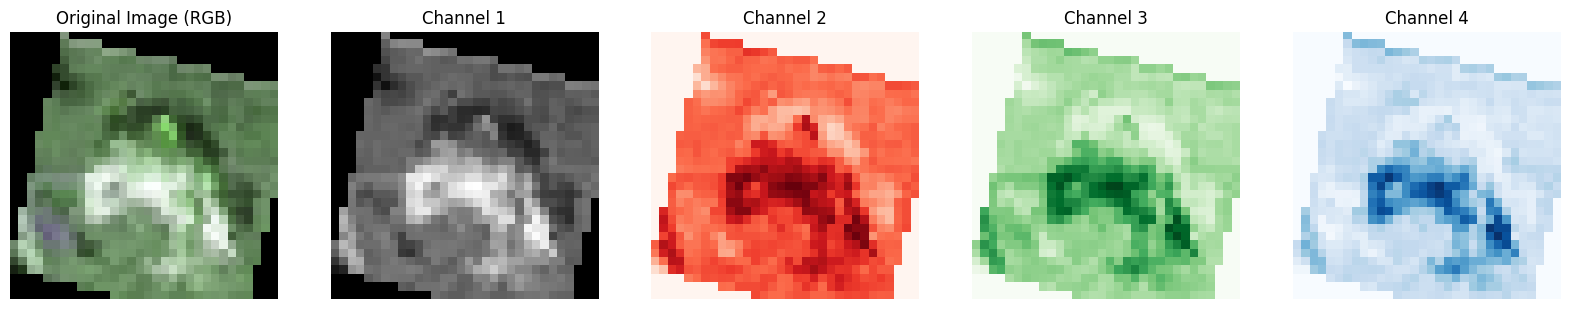

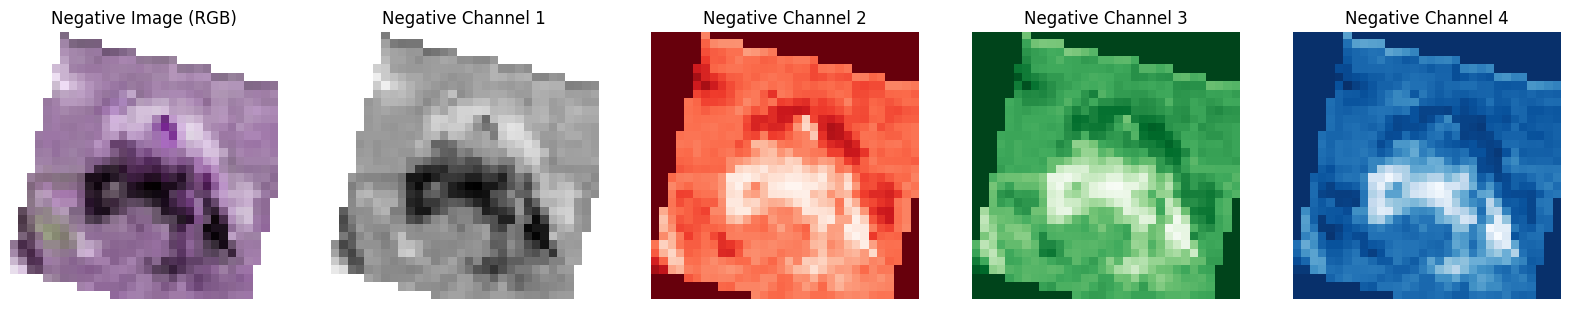

In [29]:
import matplotlib.pyplot as plt

# Prendo un'immagine tra quelle di train
image, label = train_data[0]  # La prima immagine del dataset per esempio

# Converto da [-1,1] a [0,1] per la visualizzazione corretta con matplotlib
image = (image + 1) / 2

print("Shape:", image.shape)  # (4, 32, 32)
print("Tipo di dato:", image.dtype)  # float32
print("Min:", image.min().item(), "Max:", image.max().item())  # Controllo il range dei valori
print("Classe:", cifar10_classes[label]) # Vedo qual'è la classe dell'immagine scelta

# Elenco di colormap diverse da utilizzare per ogni canale
colormaps = ['gray', 'Reds', 'Greens', 'Blues']

# Creo il subplot (una riga) per visualizzare ogni canale
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Mostro l'immagine originale (RGB) (trasposta per matplotlib)
rgb_image = image[:3].permute(1, 2, 0)  # Da (3, 32, 32) a (32, 32, 3)
axes[0].imshow(rgb_image)
axes[0].set_title("Original Image (RGB)")
axes[0].axis('off')

# Mostro i canali
for i in range(4):
    axes[i+1].imshow(image[i], cmap=colormaps[i])
    axes[i+1].set_title(f'Channel {i+1}')
    axes[i+1].axis('off')

plt.show()

# Visualizzare il negativo
image_neg = 1 - image  # Inversione dei colori

# Stesso procedimento di prima
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

rgb_image_neg = image_neg[:3].permute(1, 2, 0)
axes[0].imshow(rgb_image_neg)
axes[0].set_title("Negative Image (RGB)")
axes[0].axis('off')

for i in range(4):
    axes[i+1].imshow(image_neg[i], cmap=colormaps[i])
    axes[i+1].set_title(f'Negative Channel {i+1}')
    axes[i+1].axis('off')

plt.show()

# Nota: Potrebbero esserci bordi neri a causa delle trasformazioni nel preprocessing

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

In [31]:
"""
# Definisco il mio layer convoluzionale quaternionico
class QuaternionConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(QuaternionConv2D, self).__init__()
        self.in_channels = in_channels // 4
        self.out_channels = out_channels // 4
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Definisco i pesi per i 4 canali
        self.r_weight = nn.Parameter(torch.randn(self.out_channels, self.in_channels, kernel_size, kernel_size))
        self.i_weight = nn.Parameter(torch.randn(self.out_channels, self.in_channels, kernel_size, kernel_size))
        self.j_weight = nn.Parameter(torch.randn(self.out_channels, self.in_channels, kernel_size, kernel_size))
        self.k_weight = nn.Parameter(torch.randn(self.out_channels, self.in_channels, kernel_size, kernel_size))

    def forward(self, x):
        r, i, j, k = torch.chunk(x, 4, dim=1)  # Dividiamo il tensore di input nei 4 componenti

        print(f'dimensione canale input: {r.shape}, dimensione peso: {self.r_weight.shape}')

        # Convoluzione quaternionica su ciascun componente
        r_out = F.conv2d(r, self.r_weight, stride=self.stride, padding=self.padding) - \
               F.conv2d(i, self.i_weight, stride=self.stride, padding=self.padding) - \
               F.conv2d(j, self.j_weight, stride=self.stride, padding=self.padding) - \
               F.conv2d(k, self.k_weight, stride=self.stride, padding=self.padding)

        i_out = F.conv2d(r, self.i_weight, stride=self.stride, padding=self.padding) + \
               F.conv2d(i, self.r_weight, stride=self.stride, padding=self.padding) + \
               F.conv2d(j, self.k_weight, stride=self.stride, padding=self.padding) - \
               F.conv2d(k, self.j_weight, stride=self.stride, padding=self.padding)

        j_out = F.conv2d(r, self.j_weight, stride=self.stride, padding=self.padding) - \
               F.conv2d(i, self.k_weight, stride=self.stride, padding=self.padding) + \
               F.conv2d(j, self.r_weight, stride=self.stride, padding=self.padding) + \
               F.conv2d(k, self.i_weight, stride=self.stride, padding=self.padding)

        k_out = F.conv2d(r, self.k_weight, stride=self.stride, padding=self.padding) + \
               F.conv2d(i, self.j_weight, stride=self.stride, padding=self.padding) - \
               F.conv2d(j, self.i_weight, stride=self.stride, padding=self.padding) + \
               F.conv2d(k, self.r_weight, stride=self.stride, padding=self.padding)

        # Concatenazione dei risultati in un unico tensor
        return torch.cat([r_out, i_out, j_out, k_out], dim=1)  # L'output avrà 4 canali
"""

"\n# Definisco il mio layer convoluzionale quaternionico\nclass QuaternionConv2D(nn.Module):\n    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):\n        super(QuaternionConv2D, self).__init__()\n        self.in_channels = in_channels // 4\n        self.out_channels = out_channels // 4\n        self.kernel_size = kernel_size\n        self.stride = stride\n        self.padding = padding\n\n        # Definisco i pesi per i 4 canali\n        self.r_weight = nn.Parameter(torch.randn(self.out_channels, self.in_channels, kernel_size, kernel_size))\n        self.i_weight = nn.Parameter(torch.randn(self.out_channels, self.in_channels, kernel_size, kernel_size))\n        self.j_weight = nn.Parameter(torch.randn(self.out_channels, self.in_channels, kernel_size, kernel_size))\n        self.k_weight = nn.Parameter(torch.randn(self.out_channels, self.in_channels, kernel_size, kernel_size))\n\n    def forward(self, x):\n        r, i, j, k = torch.chunk(x, 4, dim=1) 

In [32]:
"""
class QuaternionConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1, bias = True):
        super(QuaternionConv2D, self).__init__()
        self.in_channels = in_channels // 4
        self.out_channels = out_channels // 4
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Matrice di pesi per la convoluzione quaternionica
        self.r_weight  = nn.Parameter(torch.Tensor(self.out_channels, self.in_channels, kernel_size, kernel_size))
        self.i_weight  = nn.Parameter(torch.Tensor(self.out_channels, self.in_channels, kernel_size, kernel_size))
        self.j_weight  = nn.Parameter(torch.Tensor(self.out_channels, self.in_channels, kernel_size, kernel_size))
        self.k_weight  = nn.Parameter(torch.Tensor(self.out_channels, self.in_channels, kernel_size, kernel_size))

        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_channels, 4))  # 4 componenti
        else:
            self.register_parameter('bias', None)

        self.init_weights()
    
    def init_weights(self):
        """Applica Xavier Uniform agli strati quaternionici."""
        for weight in [self.r_weight, self.i_weight, self.j_weight, self.k_weight]:
            init.xavier_uniform_(weight)
    
        if self.bias is not None:
            init.zeros_(self.bias)
            
    def normalize_weights(self):
        """Normalizza i pesi quaternionici affinché abbiano norma unitaria."""
        norm = torch.sqrt(self.r_weight**2 + self.i_weight**2 + self.j_weight**2 + self.k_weight**2 + 1e-6)
        self.r_weight.data /= norm
        self.i_weight.data /= norm
        self.j_weight.data /= norm
        self.k_weight.data /= norm

    def forward(self, x):
        if self.training:
            self.normalize_weights()
        weights = torch.cat([torch.cat([self.r_weight, -self.i_weight, -self.j_weight, -self.k_weight], dim=0),
                             torch.cat([self.i_weight,  self.r_weight, -self.k_weight,  self.j_weight], dim=0),
                             torch.cat([self.j_weight,  self.k_weight,  self.r_weight, -self.i_weight], dim=0),
                             torch.cat([self.k_weight, -self.j_weight,  self.i_weight,  self.r_weight], dim=0)
                             ], dim=1)

        # print(f'matrice dei pesi: {weights.shape}')
        
        # Convoluzione unica con la matrice dei pesi quaternionici
        output = F.conv2d(x, weights, stride=self.stride, padding=self.padding)
        
        return output  # Il risultato ha già 4 componenti
        """

SyntaxError: invalid syntax (2612366663.py, line 25)

In [33]:
class QuaternionConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1, bias=True):
        super(QuaternionConv2D, self).__init__()
        # I canali devono essere divisibili per 4
        assert in_channels % 4 == 0 and out_channels % 4 == 0
        
        self.in_channels = in_channels // 4
        self.out_channels = out_channels // 4
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        # Pesi per ogni componente quaternionica
        self.r_weight = nn.Parameter(torch.Tensor(self.out_channels, self.in_channels, kernel_size, kernel_size))
        self.i_weight = nn.Parameter(torch.Tensor(self.out_channels, self.in_channels, kernel_size, kernel_size))
        self.j_weight = nn.Parameter(torch.Tensor(self.out_channels, self.in_channels, kernel_size, kernel_size))
        self.k_weight = nn.Parameter(torch.Tensor(self.out_channels, self.in_channels, kernel_size, kernel_size))
        
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        
        self.init_weights()
    
    def init_weights(self):
        for weight in [self.r_weight, self.i_weight, self.j_weight, self.k_weight]:
            nn.init.xavier_uniform_(weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)
    
    def forward(self, x):
        batch_size = x.shape[0]
        
        # Reshape input da (batch, channels, H, W) a (batch, q_channels, 4, H, W)
        x = x.view(batch_size, self.in_channels, 4, x.shape[2], x.shape[3])
        
        # Separa le componenti quaternioniche
        r, i, j, k = x[:, :, 0], x[:, :, 1], x[:, :, 2], x[:, :, 3]
        
        # Moltiplicazione quaternionica tramite convoluzione
        r_out = (F.conv2d(r, self.r_weight, stride=self.stride, padding=self.padding) -
                 F.conv2d(i, self.i_weight, stride=self.stride, padding=self.padding) -
                 F.conv2d(j, self.j_weight, stride=self.stride, padding=self.padding) -
                 F.conv2d(k, self.k_weight, stride=self.stride, padding=self.padding))
        
        i_out = (F.conv2d(r, self.i_weight, stride=self.stride, padding=self.padding) +
                 F.conv2d(i, self.r_weight, stride=self.stride, padding=self.padding) +
                 F.conv2d(j, self.k_weight, stride=self.stride, padding=self.padding) -
                 F.conv2d(k, self.j_weight, stride=self.stride, padding=self.padding))
        
        j_out = (F.conv2d(r, self.j_weight, stride=self.stride, padding=self.padding) -
                 F.conv2d(i, self.k_weight, stride=self.stride, padding=self.padding) +
                 F.conv2d(j, self.r_weight, stride=self.stride, padding=self.padding) +
                 F.conv2d(k, self.i_weight, stride=self.stride, padding=self.padding))
        
        k_out = (F.conv2d(r, self.k_weight, stride=self.stride, padding=self.padding) +
                 F.conv2d(i, self.j_weight, stride=self.stride, padding=self.padding) -
                 F.conv2d(j, self.i_weight, stride=self.stride, padding=self.padding) +
                 F.conv2d(k, self.r_weight, stride=self.stride, padding=self.padding))
        
        # Ricostruisci il formato quaternionico
        output = torch.stack([r_out, i_out, j_out, k_out], dim=2)
        output = output.view(batch_size, self.out_channels * 4, output.shape[3], output.shape[4])
        
        if self.bias is not None:
            output = output + self.bias.view(1, -1, 1, 1)
        
        return output

In [34]:
"""# Definisco un layer lineare quaternionico
class QuaternionLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(QuaternionLinear, self).__init__()

        self.in_features = in_features // 4
        self.out_features = out_features // 4

        self.r = nn.Linear(self.in_features, self.out_features)
        self.i = nn.Linear(self.in_features, self.out_features)
        self.j = nn.Linear(self.in_features, self.out_features)
        self.k = nn.Linear(self.in_features, self.out_features)

    def forward(self, x):
        # Divisione nei 4 componenti
        r, i, j, k = torch.chunk(x, 4, dim=1)
    
        # Applicare il layer lineare
        r_out = self.r(r) - self.i(i) - self.j(j) - self.k(k)
        i_out = self.r(i) + self.i(r) + self.j(k) - self.k(j)
        j_out = self.r(j) - self.i(k) + self.j(r) + self.k(i)
        k_out = self.r(k) + self.i(j) - self.j(i) + self.k(r)
    
        # Concatenazione dei risultati
        return torch.cat([r_out, i_out, j_out, k_out], dim=-1)
        """

'# Definisco un layer lineare quaternionico\nclass QuaternionLinear(nn.Module):\n    def __init__(self, in_features, out_features):\n        super(QuaternionLinear, self).__init__()\n\n        self.in_features = in_features // 4\n        self.out_features = out_features // 4\n\n        self.r = nn.Linear(self.in_features, self.out_features)\n        self.i = nn.Linear(self.in_features, self.out_features)\n        self.j = nn.Linear(self.in_features, self.out_features)\n        self.k = nn.Linear(self.in_features, self.out_features)\n\n    def forward(self, x):\n        # Divisione nei 4 componenti\n        r, i, j, k = torch.chunk(x, 4, dim=1)\n    \n        # Applicare il layer lineare\n        r_out = self.r(r) - self.i(i) - self.j(j) - self.k(k)\n        i_out = self.r(i) + self.i(r) + self.j(k) - self.k(j)\n        j_out = self.r(j) - self.i(k) + self.j(r) + self.k(i)\n        k_out = self.r(k) + self.i(j) - self.j(i) + self.k(r)\n    \n        # Concatenazione dei risultati\n     

In [35]:
class QuaternionLinear(nn.Module):
    def __init__(self, in_features, out_features):
        """
        Args:
            in_features: numero di percettroni quaternionici in input
            out_features: numero di percettroni quaternionici in output
        """
        super(QuaternionLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Ogni percettrone quaternionico ha 4 componenti
        # I pesi sono matrici (out_features, in_features)
        self.r = nn.Linear(self.in_features, self.out_features, bias=False)
        self.i = nn.Linear(self.in_features, self.out_features, bias=False)
        self.j = nn.Linear(self.in_features, self.out_features, bias=False)
        self.k = nn.Linear(self.in_features, self.out_features, bias=False)
        
        # Bias quaternionico
        self.bias = nn.Parameter(torch.zeros(out_features * 4))
        
    def forward(self, x):
        """
        Args:
            x: tensore di forma (batch, in_features * 4)
               dove le componenti sono organizzate come [r1,i1,j1,k1, r2,i2,j2,k2, ...]
        Returns:
            tensore di forma (batch, out_features * 4)
        """
        batch_size = x.shape[0]
        
        # Riorganizza l'input: da (batch, in_features*4) a (batch, in_features, 4)
        x = x.view(batch_size, self.in_features, 4)
        
        # Separa le componenti quaternioniche
        r = x[:, :, 0]  # (batch, in_features)
        i = x[:, :, 1]  # (batch, in_features)
        j = x[:, :, 2]  # (batch, in_features)
        k = x[:, :, 3]  # (batch, in_features)
        
        # Moltiplicazione quaternionica: (a + bi + cj + dk) * (e + fi + gj + hk)
        # Risultato: (ae-bf-cg-dh) + (af+be+ch-dg)i + (ag-bh+ce+df)j + (ah+bg-cf+de)k
        
        r_out = self.r(r) - self.i(i) - self.j(j) - self.k(k)
        i_out = self.r(i) + self.i(r) + self.j(k) - self.k(j)
        j_out = self.r(j) - self.i(k) + self.j(r) + self.k(i)
        k_out = self.r(k) + self.i(j) - self.j(i) + self.k(r)
        
        # Ricomponi il risultato: (batch, out_features, 4)
        output = torch.stack([r_out, i_out, j_out, k_out], dim=2)
        
        # Riorganizza in formato piatto: (batch, out_features*4)
        output = output.view(batch_size, self.out_features * 4)
        
        # Aggiungi bias
        output = output + self.bias
        
        return output

In [36]:
"""
# Definisco una 'split' relu, che viene applicata ad ogni componente del quaternione
# La dimensione del tensore non è più (batch_size, 4, weight, height), ma (batch_size, 4, weight * height), quindi ho una dimensione in meno
class QuaternionReLU(torch.nn.Module):
    def __init__(self):
        super(QuaternionReLU, self).__init__()

    def forward(self, input):
        # Separiamo le 4 componenti del quaternione
        real = input[:, 0, :]
        i = input[:, 1, :]
        j = input[:, 2, :]
        k = input[:, 3, :]

        # Applichiamo la ReLU a ciascuna componente
        real = F.relu(real)
        i = F.relu(i)
        j = F.relu(j)
        k = F.relu(k)

        # Riconstruire il quaternion con le componenti aggiornate
        return torch.stack((real, i, j, k), dim=1)
        """

"\n# Definisco una 'split' relu, che viene applicata ad ogni componente del quaternione\n# La dimensione del tensore non è più (batch_size, 4, weight, height), ma (batch_size, 4, weight * height), quindi ho una dimensione in meno\nclass QuaternionReLU(torch.nn.Module):\n    def __init__(self):\n        super(QuaternionReLU, self).__init__()\n\n    def forward(self, input):\n        # Separiamo le 4 componenti del quaternione\n        real = input[:, 0, :]\n        i = input[:, 1, :]\n        j = input[:, 2, :]\n        k = input[:, 3, :]\n\n        # Applichiamo la ReLU a ciascuna componente\n        real = F.relu(real)\n        i = F.relu(i)\n        j = F.relu(j)\n        k = F.relu(k)\n\n        # Riconstruire il quaternion con le componenti aggiornate\n        return torch.stack((real, i, j, k), dim=1)\n        "

In [37]:
class QuaternionReLU(torch.nn.Module):
    def __init__(self):
        super(QuaternionReLU, self).__init__()
    
    def forward(self, input):
        if len(input.shape) == 4:  # Conv layers: (batch, channels, H, W)
            batch_size, channels, height, width = input.shape
            assert channels % 4 == 0
            q_channels = channels // 4
            
            # Reshape per separare le componenti quaternioniche
            x = input.view(batch_size, q_channels, 4, height, width)
            
            # Applica ReLU a ogni componente
            x = F.relu(x)
            
            # Riporta al formato originale
            return x.view(batch_size, channels, height, width)
            
        else:  # FC layers: (batch, features)
            batch_size = input.shape[0]
            features = input.shape[1]
            assert features % 4 == 0
            
            # Reshape per separare le componenti quaternioniche
            x = input.view(batch_size, features // 4, 4)
            
            # Applica ReLU a ogni componente
            x = F.relu(x)
            
            # Riporta al formato originale
            return x.view(batch_size, features)

In [38]:
"""
# Definisco un flattener quaternionico che mantiene i 4 canali
def quaternion_flatten(x):
    batch_size, channels, height, width = x.shape
    q_channels = channels // 16
    return x.view(batch_size, q_channels, 16 * height * width)

def quaternion_flatten(x):
    batch_size = x.shape[0]  # Manteniamo la dimensione del batch
    return x.view(batch_size, -1)  # Flatten mantenendo batch_size
    """

'\n# Definisco un flattener quaternionico che mantiene i 4 canali\ndef quaternion_flatten(x):\n    batch_size, channels, height, width = x.shape\n    q_channels = channels // 16\n    return x.view(batch_size, q_channels, 16 * height * width)\n\ndef quaternion_flatten(x):\n    batch_size = x.shape[0]  # Manteniamo la dimensione del batch\n    return x.view(batch_size, -1)  # Flatten mantenendo batch_size\n    '

In [39]:
def quaternion_flatten(x):
    batch_size, channels, height, width = x.shape
    # Assicurati che channels sia divisibile per 4
    assert channels % 4 == 0
    
    # Mantieni la struttura quaternionica: (batch, channels, height*width)
    return x.view(batch_size, channels, height * width).view(batch_size, -1)

In [40]:
class QuaternionFullyConnected(nn.Module):
    def __init__(self):
        super(QuaternionFullyConnected, self).__init__()
        
        # Input: (4, 32, 32) -> 32*32 = 1024 percettroni con 4 features quaternioniche ciascuno
        # Architettura classica fully connected con riduzione progressiva
        
        self.fc1 = QuaternionLinear(1024, 512)   # 1024 percettroni -> 512
        self.fc2 = QuaternionLinear(512, 256)    # 512 -> 256
        self.fc3 = QuaternionLinear(256, 128)    # 256 -> 128
        self.fc4 = QuaternionLinear(128, 64)     # 128 -> 64
        
        # Layer finale: da quaternionico a scalare
        # 64 features quaternioniche = 16 features scalari
        self.fc_final = nn.Linear(16, 10)  # 64 // 4 = 16
        
        self.qrelu = QuaternionReLU()
        self.dropout = nn.Dropout(0.5)  # Dropout per evitare overfitting
    
    def forward(self, x):
        # Input: (batch, 4, 32, 32)
        
        # Flatten mantenendo struttura quaternionica: da (batch, 4, 32, 32) a (batch, 1024*4)
        batch_size = x.shape[0]
        x = x.view(batch_size, 4, -1)  # (batch, 4, 1024)
        x = x.permute(0, 2, 1)         # (batch, 1024, 4)
        x = x.contiguous().view(batch_size, -1)  # (batch, 1024*4)
        
        # Sequenza di layer fully connected quaternionici
        x = self.qrelu(self.fc1(x))
        x = self.dropout(x)
        # (batch, 512*4)
        
        x = self.qrelu(self.fc2(x))
        x = self.dropout(x)
        # (batch, 256*4)
        
        x = self.qrelu(self.fc3(x))
        x = self.dropout(x)
        # (batch, 128*4)
        
        x = self.qrelu(self.fc4(x))
        # (batch, 64*4)
        
        # Estrai solo la parte scalare per la classificazione
        x = x.view(x.shape[0], -1, 4)[:, :, 0]  # Prendi solo la componente scalare
        # (batch, 64)
        
        x = self.fc_final(x)
        # (batch, 10)
        
        return x

# Funzione utility per contare i parametri
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [41]:
class QCNN(nn.Module):
    def __init__(self):
        super(QCNN, self).__init__()
        self.conv1 = QuaternionConv2D(4, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = QuaternionConv2D(16, 64, kernel_size=3, stride=1, padding=1)
        
        # Calcolo corretto delle dimensioni dopo conv + pooling
        # Input: (4, 32, 32) -> conv1 -> (16, 32, 32) -> pool -> (16, 16, 16)
        # -> conv2 -> (64, 16, 16) -> pool -> (64, 8, 8)
        # Features totali: 64 * 8 * 8 = 4096
        self.fc1 = QuaternionLinear(4096, 512)
        self.fc2 = QuaternionLinear(512, 1024)
        
        # Layer finale: da quaternionico a scalare
        # 1024 features quaternioniche = 256 features scalari
        self.fc3 = nn.Linear(256, 10)  # 1024 // 4 = 256
        
        self.qrelu = QuaternionReLU()
        self.flatten = quaternion_flatten
    
    def forward(self, x):
        # print(f"Input shape: {x.shape}")  # (batch, 4, 32, 32)
        
        x = self.qrelu(self.conv1(x))
        # print(f"After conv1: {x.shape}")  # (batch, 16, 32, 32)
        
        x = F.max_pool2d(x, 2)
        # print(f"After maxpool1: {x.shape}")  # (batch, 16, 16, 16)
        
        x = self.qrelu(self.conv2(x))
        # print(f"After conv2: {x.shape}")  # (batch, 64, 16, 16)
        
        x = F.max_pool2d(x, 2)
        # print(f"After maxpool2: {x.shape}")  # (batch, 64, 8, 8)
        
        x = self.flatten(x)
        # print(f"After flatten: {x.shape}")  # (batch, 4096)
        
        x = self.qrelu(self.fc1(x))
        # print(f"After fc1: {x.shape}")  # (batch, 512)
        
        x = self.qrelu(self.fc2(x))
        # print(f"After fc2: {x.shape}")  # (batch, 1024)
        
        # Estrai solo la parte scalare per la classificazione
        x = x.view(x.shape[0], -1, 4)[:, :, 0]  # Prendi solo la componente scalare
        # print(f"After quaternion extraction: {x.shape}")  # (batch, 256)
        
        x = self.fc3(x)
        # print(f"Final output: {x.shape}")  # (batch, 10)
        
        return x

In [42]:
"""
import torch
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = QCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)


        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()

        # Clipping dei gradienti per evitare esplosioni
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # Stampa la norma media dei gradienti
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                total_norm += p.grad.norm().item()

        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch}[{batch_idx * len(data)}/{len(loaders["train"].dataset)} ({100. * batch_idx / len(loaders["train"]):.0f}%)]\t{loss.item():.6f}')

def test():
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim = 1, keepdim = True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders['test'].dataset)
    print(f'\nTest set: Avarage loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f}%\n)')
    """

'\nimport torch\nimport torch.optim as optim\n\ndevice = torch.device(\'cuda\' if torch.cuda.is_available() else \'cpu\')\nmodel = QCNN().to(device)\noptimizer = optim.Adam(model.parameters(), lr = 0.0001)\nloss_fn = nn.CrossEntropyLoss()\n\ndef train(epoch):\n    model.train()\n    for batch_idx, (data, target) in enumerate(loaders[\'train\']):\n        data, target = data.to(device), target.to(device)\n\n\n        optimizer.zero_grad()\n        output = model(data)\n        loss = loss_fn(output, target)\n        loss.backward()\n\n        # Clipping dei gradienti per evitare esplosioni\n        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)\n        # Stampa la norma media dei gradienti\n        total_norm = 0\n        for p in model.parameters():\n            if p.grad is not None:\n                total_norm += p.grad.norm().item()\n\n        optimizer.step()\n\n        if batch_idx % 100 == 0:\n            print(f\'Train Epoch: {epoch}[{batch_idx * len(data)}/{l

In [43]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = QuaternionFullyConnected().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Scheduler opzionale per ridurre lr durante training
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

def monitor_gradients(model):
    """Monitora la norma media dei gradienti"""
    total_norm = 0
    param_count = 0
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norm = param.grad.norm()
            total_norm += grad_norm.item()
            param_count += 1
    return total_norm / param_count if param_count > 0 else 0

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        # Rimosso data.requires_grad = True
        
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        
        # Clipping dei gradienti per evitare esplosioni
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Monitoring gradienti (solo per alcuni batch)
        if batch_idx % 100 == 0:
            grad_norm = monitor_gradients(model)
            print(f'Grad norm: {grad_norm:.4f}')
        
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} ({100. * batch_idx / len(loaders["train"]):.0f}%)]\tLoss: {loss.item():.6f}')

def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    # Corretto: dividi per numero di batch, non per dataset size
    test_loss /= len(loaders['test'])
    
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f}%)\n')

# Training principale
num_epochs = 10

print(f"Training su {device}")
print(f"Numero parametri: {sum(p.numel() for p in model.parameters())}")

for epoch in range(1, num_epochs + 1):
    print(f"\n--- Epoch {epoch}/{num_epochs} ---")
    train(epoch)
    test()
    
    # Aggiorna learning rate
    scheduler.step()
    print(f"Learning rate: {scheduler.get_last_lr()[0]:.6f}")
    
    # Salva checkpoints ogni 5 epoche
    if epoch % 5 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
        }, f'qcnn_checkpoint_epoch_{epoch}.pth')
        print(f"Checkpoint salvato: qcnn_checkpoint_epoch_{epoch}.pth")

print("Training completato!")

Training su cpu
Numero parametri: 2789290

--- Epoch 1/10 ---


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x64 and 16x10)

In [ ]:
"""model = QCNN()
x = torch.randn(128, 4, 32, 32)  # Batch di esempio con 128 immagini 32x32, 4 canali
output = model(x)
print(f"Output shape: {output.shape}")  # Verifica l'output"""

In [ ]:
"""for epoch in range(1, 6):
    train(epoch)
    test()"""